In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as GS
import numpy as np
import styling_funcs as style
import global_vars as gvars
%matplotlib inline

# File paths, global user vars for this notebook

In [2]:
data_folder="..results/data/output_spk_network"

# Read the data

In [3]:
def get_observable_data(filename, prefix_path=data_folder):
    data_mean = pd.read_csv(f'{prefix_path}/{filename}_Mean.csv', header=None, skiprows=1, index_col=0).T
    data_std = pd.read_csv(f'{prefix_path}/{filename}_STD.csv', header=None, skiprows=1, index_col=0).T
    return data_mean, data_std


def read_spiking_matrix(filename, prefix_path=data_folder):
    return np.load(f"{prefix_path}/{filename}.npy")

In [4]:
data_noise_mean, data_noise_corr = get_observable_data("Noise")
data_w_mean, data_w_corr = get_observable_data("WFullCon")


spk_labels = [f"n2s={val}" for val in [0.1, 0.5, 0.9]]
spk_labels += [f"wr={val}" for val in [1.5, 4.5, 7.5]]

th_noise_tuning = pd.read_csv("../data/analytics_paper/tuning_n.csv")
th_noise_corrs = pd.read_csv("../data/analytics_paper/corrs_n.csv")
th_w_tuning = pd.read_csv("../data/analytics_paper/tuning_w.csv")
th_w_corrs = pd.read_csv("../data/analytics_paper/corrs_w.csv")


spiking_data = {}
for label in spk_labels:
    spiking_data[label] = read_spiking_matrix(f"spikes_{label}")

FileNotFoundError: [Errno 2] No such file or directory: '..results/data/output_spk_network/Noise_Mean.csv'

# Well-formated graph


In [7]:
# style.two_col_size(ratio=2)
adjusted_dim =(7.9,3.1)

In [8]:
# gvars.colors['tuning']= "#6D72D8FF"#sns.color_palette('rocket_r',n_colors=12)[4]#[6]
# gvars.colors['diversity']="#18BA6CFF"#sns.color_palette('crest',n_colors=12)[4]#[1]
gvars.colors['tuning']= sns.color_palette('rocket_r',n_colors=12)[8]#[6]
gvars.colors['diversity']=sns.color_palette('crest',n_colors=12)[4]#[1]

gvars.colors['tuning']= sns.color_palette('rocket_r',n_colors=12)[8]#[6]
gvars.colors['diversity']=sns.color_palette('crest',n_colors=12)[4]#[1]

gvars.colors["EI_IN"] = sns.color_palette('rocket_r',n_colors=12)[1]
gvars.colors["EI_OUT"] = sns.color_palette('crest',n_colors=12)[-4]#[6]

NameError: name 'data_noise_mean' is not defined

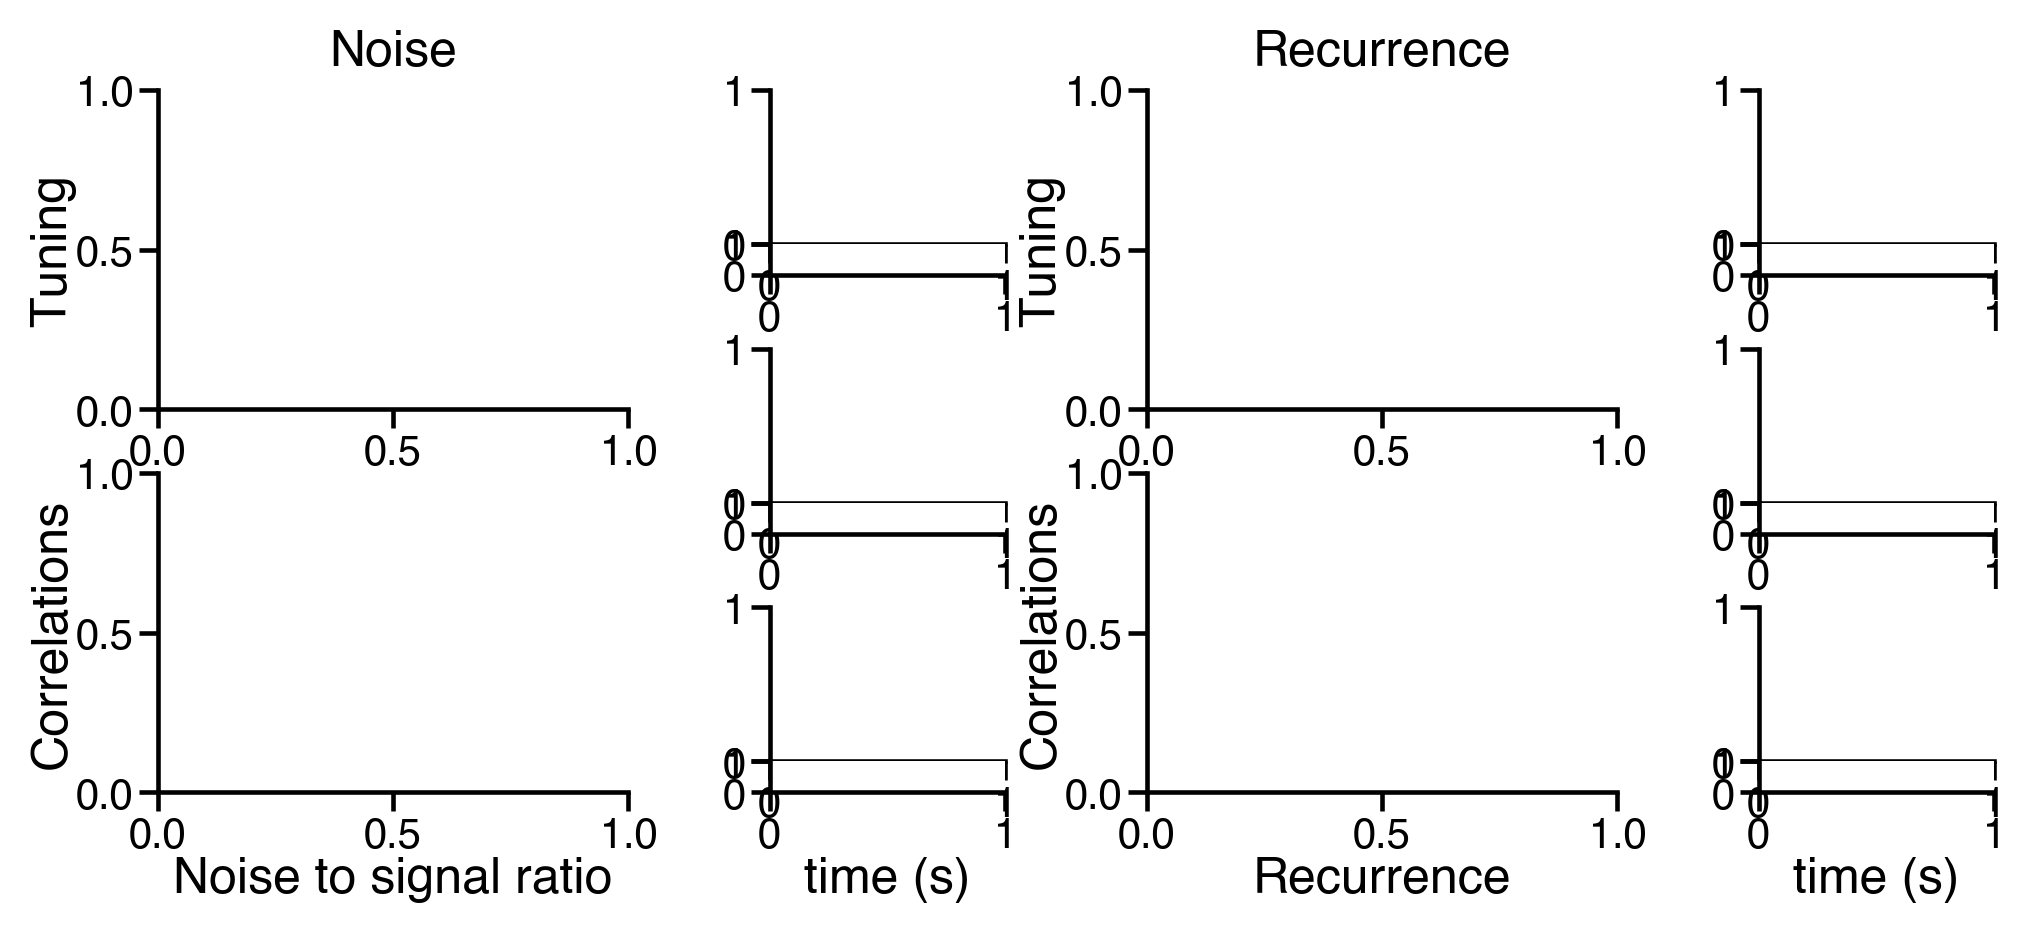

In [9]:
style.master_format()

sep_cols = 0.4
wsep = 0.3
hsep = 0.4
wratio = 0.5
hratio = 0.2 

#Figure with its four main columns
fig = plt.figure(figsize=adjusted_dim, dpi=300)
main_div = GS.GridSpec(nrows=1, ncols=4, figure=fig, wspace=sep_cols, width_ratios=[1.0, wratio, 1.0, wratio])

#Each one of this 2x2 figures will be divided in two columns, where the right one is divided into two plots
div = []
for j in range(4):
    
    #Even columns are for plotting curves
    if j%2 == 0:
        v_div = GS.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=main_div[j])
        
    #Odd colums are for raster plots and have 3 divisions, each one with two unequal plots which will share an axis
    else:

        #Divide it in 3 equal parts...
        v_div_big = GS.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=main_div[j], hspace=hsep)
        v_div = []
        #And each one in two unequal divisions with custom space...
        for i in range(3):
            v_div += GS.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=v_div_big[i], height_ratios=[1.0, hratio], hspace=0.0)
    
    #Select the axes we want to add to our thing and append them for later    
    div.append(v_div)

#Get our selected panels and add them
names = ["noise", "coup"]
measure = ["tuning", "corr"]
plotype = ["spktrn", "rate"]



#Add and name all our axes
axes = {}
for j in range(4):
    index_col = j//2
    index_meas = j%2


    if index_meas == 0:
        for panel, meas in zip(div[j], measure):
            #The 4 ones with curves have names like "noise_corr" or "coup_tuning"
            curve_name = f"{names[index_col]}_{meas}"
            axes[curve_name] = fig.add_subplot(panel)
    else:
        for i in range(3):
            spkpanel, ratepanel = div[j][2*i], div[j][2*i+1]
            
            #The other ones are stuff like "noise_spktrn_1" or "coup_rate_0"
            spk_name = f"{names[index_col]}_{plotype[0]}_{i}"
            rate_name = f"{names[index_col]}_{plotype[1]}_{i}"

            
            #Make them share the axis
            axes[spk_name] = fig.add_subplot(spkpanel)
            axes[rate_name] = fig.add_subplot(ratepanel, sharex=axes[spk_name])

            



# --------- Configure axes labels



#Set title
axes["noise_tuning"].set_title('Noise')
axes["coup_tuning"].set_title('Recurrence')


#Set labels in plots...
labels = ["Noise to signal ratio", "Recurrence"]
axkeys = ["noise_corr", "coup_corr"]
for axk,label in zip(axkeys, labels):
    ax = axes[axk]
    ax.set_xlabel(label, labelpad=0.0)

    
labels = ["Tuning", "Correlations"]*2
axkeys = ["noise_tuning", "noise_corr", "coup_tuning", "coup_corr"]
for axk,label in zip(axkeys, labels):
    ax = axes[axk]
    ax.set_ylabel(label, labelpad=0.0)
    
    
axkeys = ["noise_rate_2", "coup_rate_2"]
for axk,label in zip(axkeys, labels):
    ax = axes[axk]
    ax.set_xlabel("time (s)", labelpad=0.0)
# --------- Actual plots
    
#Plot simulation
noise = data_noise_mean["noise_ratio"]
axes["noise_tuning"].plot(noise, data_noise_mean["W_Cor"], ls="none", marker=".", color=gvars.colors["tuning"], label = "Balance")
axes["noise_tuning"].plot(noise, 1-data_noise_mean["eW_Dist"], ls="none", marker=".", color=gvars.colors["diversity"], label = "Diversity")

sigma = 3
labels = ["In Group", "Betw. Groups"]
for j,curve in enumerate(["EI_IN", "EI_OUT"]):
    axes["noise_corr"].plot(noise, data_noise_mean[curve], ls="none", marker=".", color=gvars.colors[curve], label = labels[j])
    axes["noise_corr"].fill_between(noise, data_noise_mean[curve] - sigma*data_noise_corr[curve], data_noise_mean[curve] + sigma*data_noise_corr[curve], color=gvars.colors[curve], alpha=0.3, edgecolor="none")

#Plot simulation
w = data_w_mean["W"]
axes["coup_tuning"].plot(w, data_w_mean["W_Cor"], ls="none", marker=".", color=gvars.colors["tuning"])
axes["coup_tuning"].plot(w, 1-data_w_mean["eW_Dist"], ls="none", marker=".", color=gvars.colors["diversity"])

sigma = 3
for j,curve in enumerate(["EI_IN", "EI_OUT"]):
    axes["coup_corr"].plot(w, data_w_mean[curve], ls="none", marker=".", color=gvars.colors[curve])
    axes["coup_corr"].fill_between(w, data_w_mean[curve] - sigma*data_w_corr[curve], data_w_mean[curve] + sigma*data_w_corr[curve], color=gvars.colors[curve], alpha=0.3, edgecolor="none")



#Plot spiketrains
dotsize = 1.5#0.05
w_vals = np.array([0.1, 0.5, 0.9])
n2s_vals = np.array([1.5, 4.5, 7.5])
offset = 0.02

for j in range(3):
    #w = w_vals[j]
    #n2s = n2s_vals[j]
    
    for datakey, values, axkey in zip(["n2s", "wr"], [w_vals, n2s_vals], ["noise", "coup"]):
        value = values[j]
        spiketrain = spiking_data[f"{datakey}={value}"]
        exc_mask = spiketrain[:,1] < 800
        # axs[raster_name].plot(ste,gde, '|', ms=.95, color = gvars.colors["EXC"],alpha=0.5, rasterized=True)
        ax = axes[f"{axkey}_spktrn_{j}"]
        ax.plot(spiketrain[exc_mask,0], spiketrain[exc_mask,1], '|', ms=dotsize, markeredgewidth=.3,color = gvars.colors["EXC"], rasterized=False,alpha=.5)
        ax.plot(spiketrain[~exc_mask,0], spiketrain[~exc_mask,1], '|', ms=dotsize,markeredgewidth=.3, color = gvars.colors["INH"], rasterized=False,alpha=.5)
        # ax.text(0.1, 0.975, f"{datakey}={value}", transform=ax.transAxes, usetex=False)
        ax.axis('off')
        ax.set_xlim(2.5,3.)
        pos = ax.get_position()
        pos.x0 -= 0.02
        ax.set_position(pos)

        nbins = 150
        bin_size = .002
        rate, bins = np.histogram(spiketrain[:,0], np.arange(0,np.max(spiketrain[:,0]),bin_size))#,bins=nbins)
                                                        # \textbf{b.}# The increase in noise leads to a the decrease in in-group correlation, while the between-group correlation remains low.))#bins=nbins)
        ax = axes[f"{axkey}_rate_{j}"]
        ax.plot(bins[1:-1], rate[1:], color="grey", lw=0.7)
        ax.set_ylim(0,200)
        ax.set_xlim(2.5,3)
        # ax.axis('off')
        # ax.set_yticks([2500,3000])
        # ax.set_xticks([0,1,2,3])

        pos = ax.get_position()
        pos.x0 -= 0.02
        ax.set_position(pos)





#Legend formatting

axes["noise_tuning"].legend(loc=(0.05, 0.075))
axes["noise_corr"].legend(loc=(0.05, 0.075))

# -------------- Final touches

#Label all the axes
axlist = []
labelpos = []
for name in ["noise", "coup"]:
    #Select only curves and spiketrains to be labeled.
    labellist = [f"{name}_tuning", f"{name}_corr"] + [f"{name}_spktrn_{i}" for i in range(3)]
    axlist += [axes[label] for label in labellist]
    #Position for curves (2) + position for spiketrains (3)
    labelpos += [[0.8, 0.9]] * 2 + [[-0.12, 1.0]]*3 
    
#label_pos = [[0.9, 0.85] for j in range(4)]
#label_pos += [[0.9, 0.975] for j in range(4)]

style.label_axes(axlist, labelpos, uppercase=False,bracket=False)

# plt.savefig("../output/Figure_2.pdf", bbox_inches="tight", dpi=600)
# 

plt.show()